In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [113]:
class Pinard(nn.Module):
    def __init__(self, in_features, out_features, N):
        """
        replaces nn.Linear(in_features, out_features)
        """
        super().__init__()

        self.k = nn.Parameter(torch.randn((N, in_features)))
        self.v = nn.Parameter(torch.randn((N, out_features)))

    def _norm_scores(self, scores):
        norm_outputs = scores / torch.norm(scores, p=2, dim=-1, keepdim=True) * math.sqrt(scores.shape[-1])
        return F.gelu(norm_outputs)

    def forward(self, q):
        # same shapes and overall computations as standard attention with T=1 or N, n_head=1, head_dim=d1 or d2
        # q: (B, T, n_head, head_dim) = (B, 1, 1, d1) = (B, d1), k: (T, 1, d1), v: (T, 1, d2)
        scores = q @ self.k.T # (B, N)
        out = self._norm_scores(scores) @ self.v # (B, d2)
        return out

In [160]:
d2, d1 = 768, 4*768
N = (4*d2)//5
B = 4

pattention = Pinard(in_features=d1, out_features=d2, N=N)

In [161]:
x = torch.randn(B, d1)
out = pattention(x)

In [162]:
out.shape

torch.Size([4, 768])

In [163]:
d1*d2, sum(p.numel() for p in pattention.parameters())

(2359296, 2357760)

In [45]:
class Pinard(nn.Module):

    def __init__(self, in_features, out_features, N):
        super().__init__()

        self.k = nn.Parameter(torch.randn((N, in_features)))
        self.v = nn.Parameter(torch.randn((N, out_features)))

    def _norm_scores(self, scores):
        norm_outputs = scores / torch.norm(scores, p=2, dim=-1, keepdim=True) * math.sqrt(scores.shape[-1])
        return F.gelu(norm_outputs)

    def forward(self, q):
        # same shapes and overall computations as standard attention with T=1 or N, n_head=1, head_dim=d1 or d2
        # q: (B, T, n_head, head_dim) = (B, 1, 1, d1) = (B, d1), k: (T, 1, d1), v: (T, 1, d2)
        scores = q @ self.k.T # (B, N)
        out = self._norm_scores(scores) @ self.v # (B, d2)
        return out
    
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs):
        for key in ['k', 'v']:
            full_key = prefix + key
            if full_key in state_dict:
                print(full_key)
                param = state_dict[full_key]
                curr_param = getattr(self, key)
                curr_N = curr_param.size(0)
                loaded_N = param.size(0)
                assert loaded_N <= curr_N
                new_param = torch.zeros_like(curr_param)
                new_param[:loaded_N] = param[:loaded_N]
                state_dict[full_key] = new_param

        super()._load_from_state_dict(state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs)

In [46]:
class MyModel(nn.Module):
    def __init__(self, N1, N2):
        super().__init__()

        self.fc_1 = Pinard(32, 32, N1)
        self.fc_2 = Pinard(16, 16, N2)

In [47]:
model = MyModel(N1=10, N2=5)

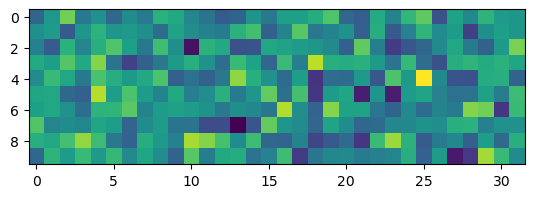

In [48]:
plt.imshow(model.fc_1.k.data)

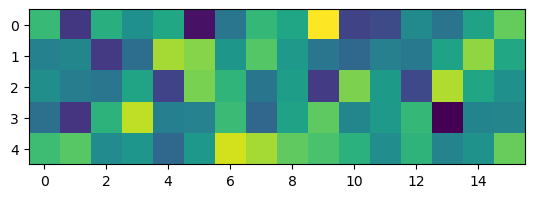

In [49]:
plt.imshow(model.fc_2.k.data)

In [50]:
torch.save(model.state_dict(), 'model.pth')

In [54]:
model2 = MyModel(N1=20, N2=14)
model2.load_state_dict(torch.load('model.pth'), strict=False)

fc_1.k
fc_1.v
fc_2.k
fc_2.v


<All keys matched successfully>

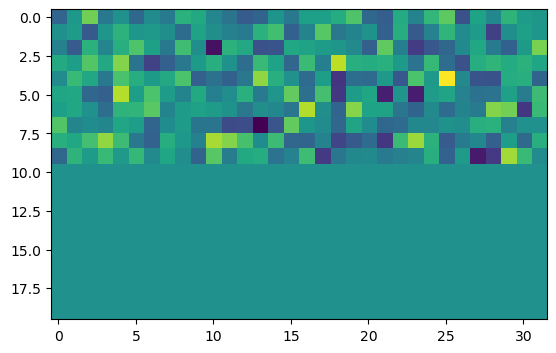

In [55]:
plt.imshow(model2.fc_1.k.data)

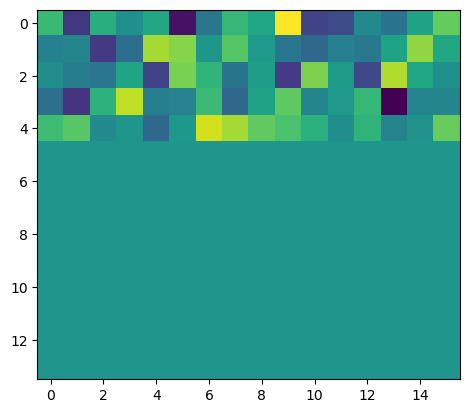

In [57]:
plt.imshow(model2.fc_2.k.data)